In [12]:
!pip install gradio

In [36]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
!pip install patchify
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2,

In [14]:
import os
import cv2
from PIL import Image
import numpy as np
import segmentation_models as sm
from matplotlib import pyplot as plt
import random

In [15]:
from keras import backend as K
from keras.models import load_model

In [16]:
import gradio as gr

In [17]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [18]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [19]:
satellite_model = load_model('/content/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [41]:
image = Image.open('/content/sample_data/Satellite-image-of-Gidadakonenahalli-Lake-Bangalore-India-The-Table-1-depicts-the.png')
#patched_images = patchify(image, (256, 256, 3), step=256)
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)
image = image[:, :, :, :3]

#img_batch = np.expand_dims(image, 0)

In [42]:
prediction = satellite_model.predict(image)

1/1 [==============================] - 1s 578ms/step


In [43]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

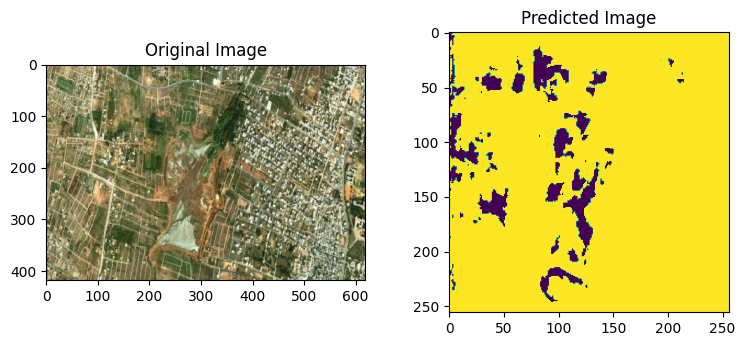

In [44]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/sample_data/Satellite-image-of-Gidadakonenahalli-Lake-Bangalore-India-The-Table-1-depicts-the.png'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [49]:
image = Image.open('/content/sample_data/onondaga_img.jpg')
#patched_images = patchify(image, (256, 256, 3), step=256)
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)
image = image[:, :, :, :3]

In [50]:
prediction = satellite_model.predict(image)

1/1 [==============================] - 0s 491ms/step


In [51]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

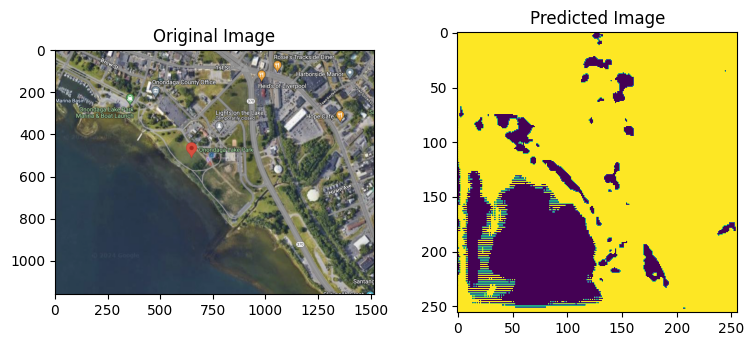

In [52]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/sample_data/onondaga_img.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [106]:
def process_input_image(image_source):
  #image_source = image_source.resize((256,256))
  #image = np.array(image_source)
  image = np.expand_dims(image_source, 0)
  image = image[:,:,:,:3]

  #images_without_alpha = images_with_alpha[:, :, :, :3].copy()

# Now you can resize the copied array without any issues
# Example:
#resized_images = np.resize(images_without_alpha, (new_shape))


  prediction = satellite_model.predict(image)
  predicted_image = np.argmax(prediction, axis=3)

  predicted_image = predicted_image[0,:,:]
  predicted_image = predicted_image * 50
  return 'Predicted Masked Image', predicted_image

In [107]:
satellite_app = gr.Blocks()

In [108]:
with satellite_app:
  gr.Markdown("Statellite Image Segmentation Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image")
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )

In [109]:
satellite_app.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4f4eeef9a5b1c54990.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 528, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 270, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1908, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1485, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://524d5c0d0318d7e37f.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://4f4eeef9a5b1c54990.gradio.live
